# EDA 및 전처리

## 공백 체크

In [ ]:
print(data.isnull().sum())
print(data.drop_duplicates(inplace=True)) # Null 값이 존재하는 행 제거
#공백없음

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64
None


## 분포 확인

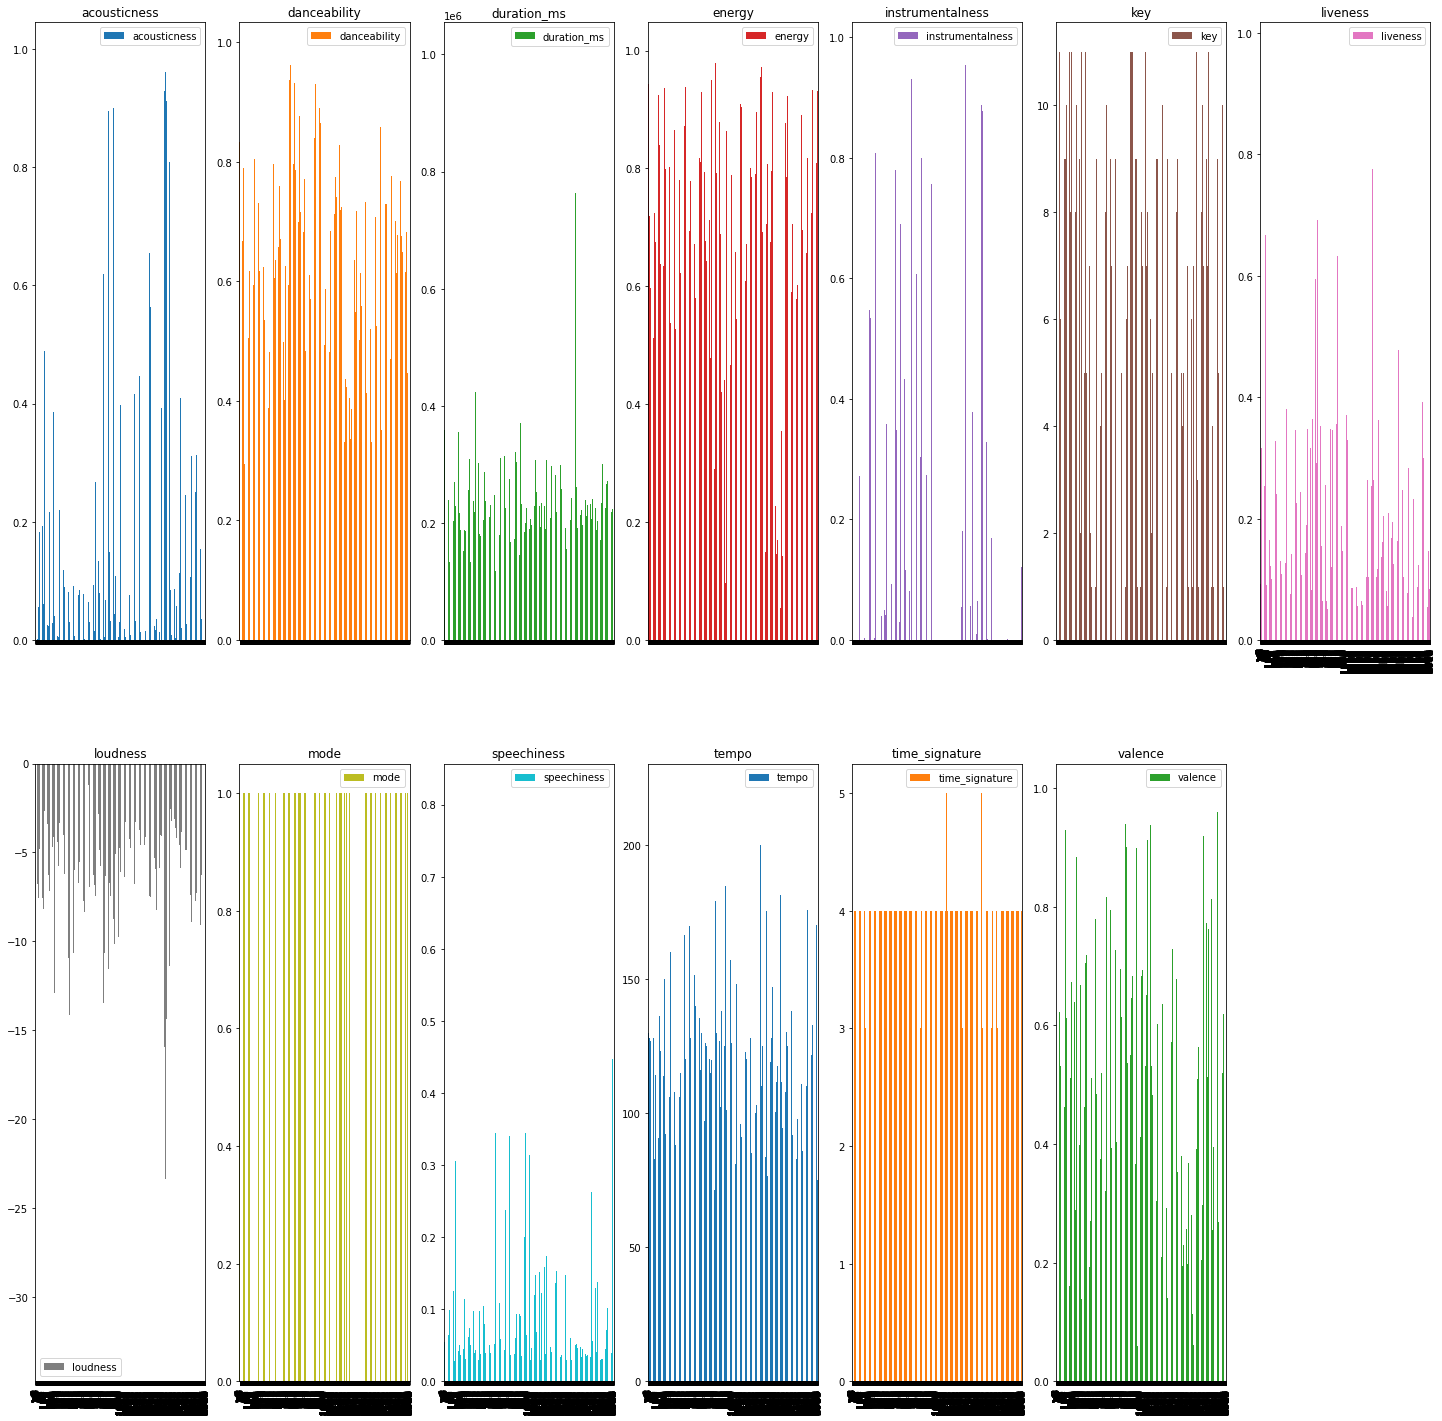

In [ ]:
data.plot(subplots=True,layout=(2,7),figsize=(25,25),kind='bar')
plt.show()

In [ ]:
flt_col,int_col,cat_col=[],[],[]
data['duration_ms']/=(1000*60)
data['duration_ms']=round(data['duration_ms'],2)
for index,dtype in zip(data.dtypes.index,data.dtypes.values):
  
  if dtype=='float64':
    flt_col.append(index)
  else:
    int_col.append(index)
flt_col,int_col

(['acousticness',
  'danceability',
  'duration_ms',
  'energy',
  'instrumentalness',
  'liveness',
  'loudness',
  'speechiness',
  'tempo',
  'valence'],
 ['key', 'mode', 'time_signature'])

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
mean,0.187747,0.618194,4.103401,0.682088,0.133083,0.190715,-7.074239,0.092138,121.625217,0.497549
std,0.259888,0.161026,1.367161,0.210299,0.273169,0.155418,3.759646,0.088896,26.681388,0.246966
min,0.000003,0.122000,0.270000,0.014800,0.000000,0.018800,-33.097000,0.023100,47.859000,0.034800
25%,0.009470,0.514000,3.330000,0.564000,0.000000,0.092200,-8.390500,0.037500,100.164000,0.296000
50%,0.063500,0.631000,3.820000,0.716000,0.000074,0.126500,-6.246000,0.054900,121.468000,0.493000
75%,0.265000,0.738000,4.502500,0.846250,0.053925,0.246250,-4.740000,0.107250,137.695250,0.692000
max,0.995000,0.984000,16.740000,0.998000,0.976000,0.969000,-0.307000,0.816000,219.331000,0.992000


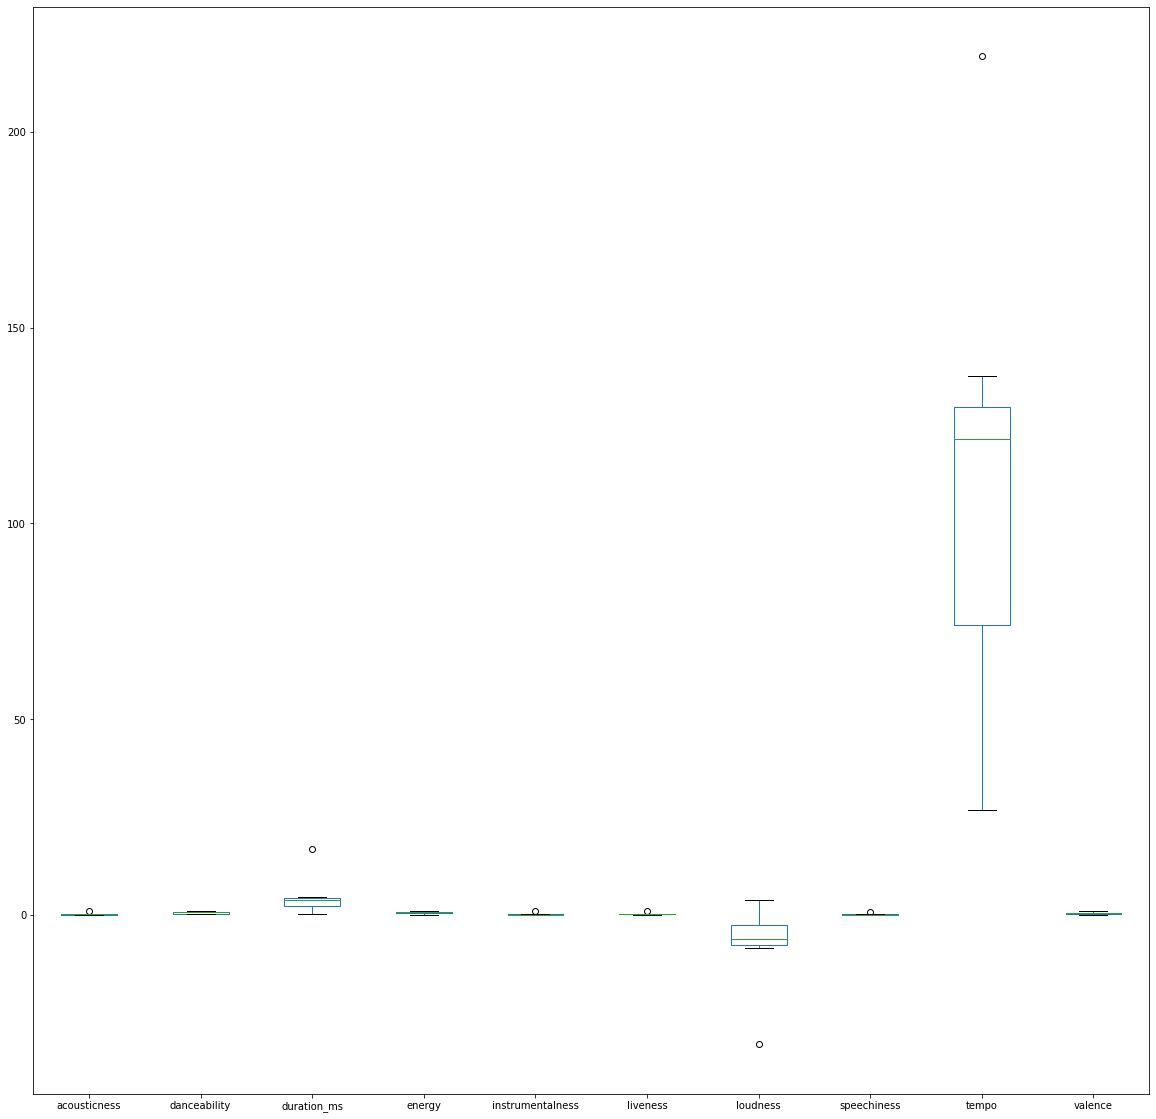

In [ ]:
import seaborn as sns
colors = sns.color_palette('hls',len(flt_col))
data.describe(include='float64').iloc[1:,:].plot(kind='box',figsize=(20,20))
data.describe(include='float64').iloc[1:,:]


#### tempo:minmax_scale 적용

In [ ]:
MAX=max(data.tempo)
MIN=min(data.tempo)
data.tempo = round(((data.tempo-MIN)/MAX),4);data.tempo

0       0.4660
1       0.5117
2       0.1239
3       0.1760
4       0.5751
         ...  
2012    0.1236
2013    0.2835
2014    0.4661
2015    0.4657
2016    0.6481
Name: tempo, Length: 2017, dtype: float64

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
mean,0.187590,0.618422,4.105151,0.681577,0.133286,0.190844,-7.085624,0.092664,0.336223,0.496815
std,0.259989,0.161029,1.366276,0.210273,0.273162,0.155453,3.761684,0.089931,0.121670,0.247195
min,0.000003,0.122000,0.270000,0.014800,0.000000,0.018800,-33.097000,0.023100,0.000000,0.034800
25%,0.009630,0.514000,3.330000,0.563000,0.000000,0.092300,-8.394000,0.037500,0.238600,0.295000
50%,0.063300,0.631000,3.820000,0.715000,0.000076,0.127000,-6.248000,0.054900,0.335400,0.492000
75%,0.265000,0.738000,4.510000,0.846000,0.054000,0.247000,-4.746000,0.108000,0.410300,0.691000
max,0.995000,0.984000,16.740000,0.998000,0.976000,0.969000,-0.307000,0.816000,0.781800,0.992000


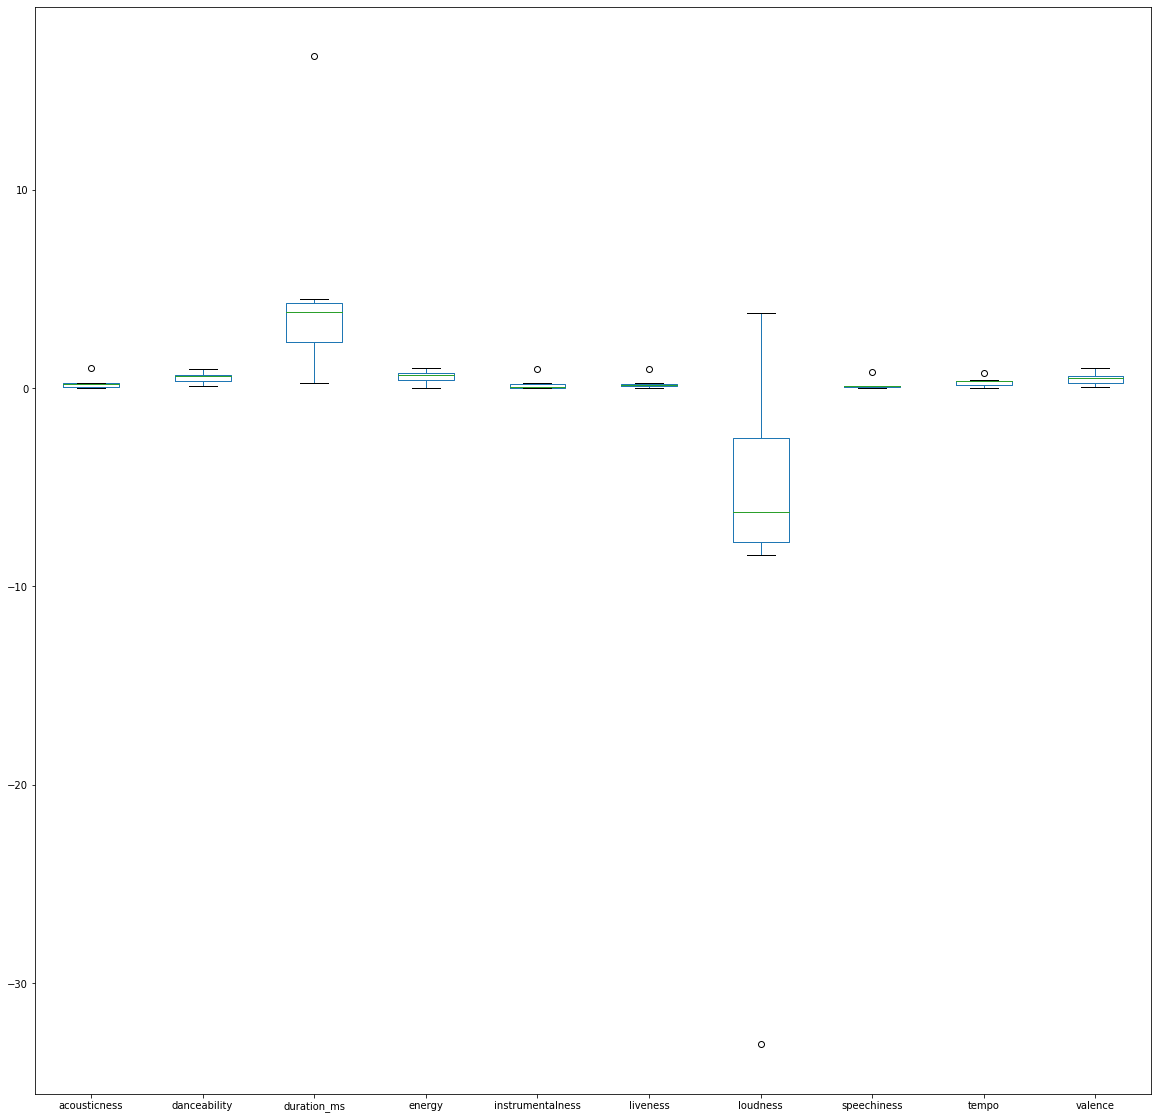

In [ ]:
import seaborn as sns
colors = sns.color_palette('hls',len(flt_col))
data.describe(include='float64').iloc[1:,:].plot(kind='box',figsize=(20,20))
data.describe(include='float64').iloc[1:,:]


time signiture 변수 제외 가능

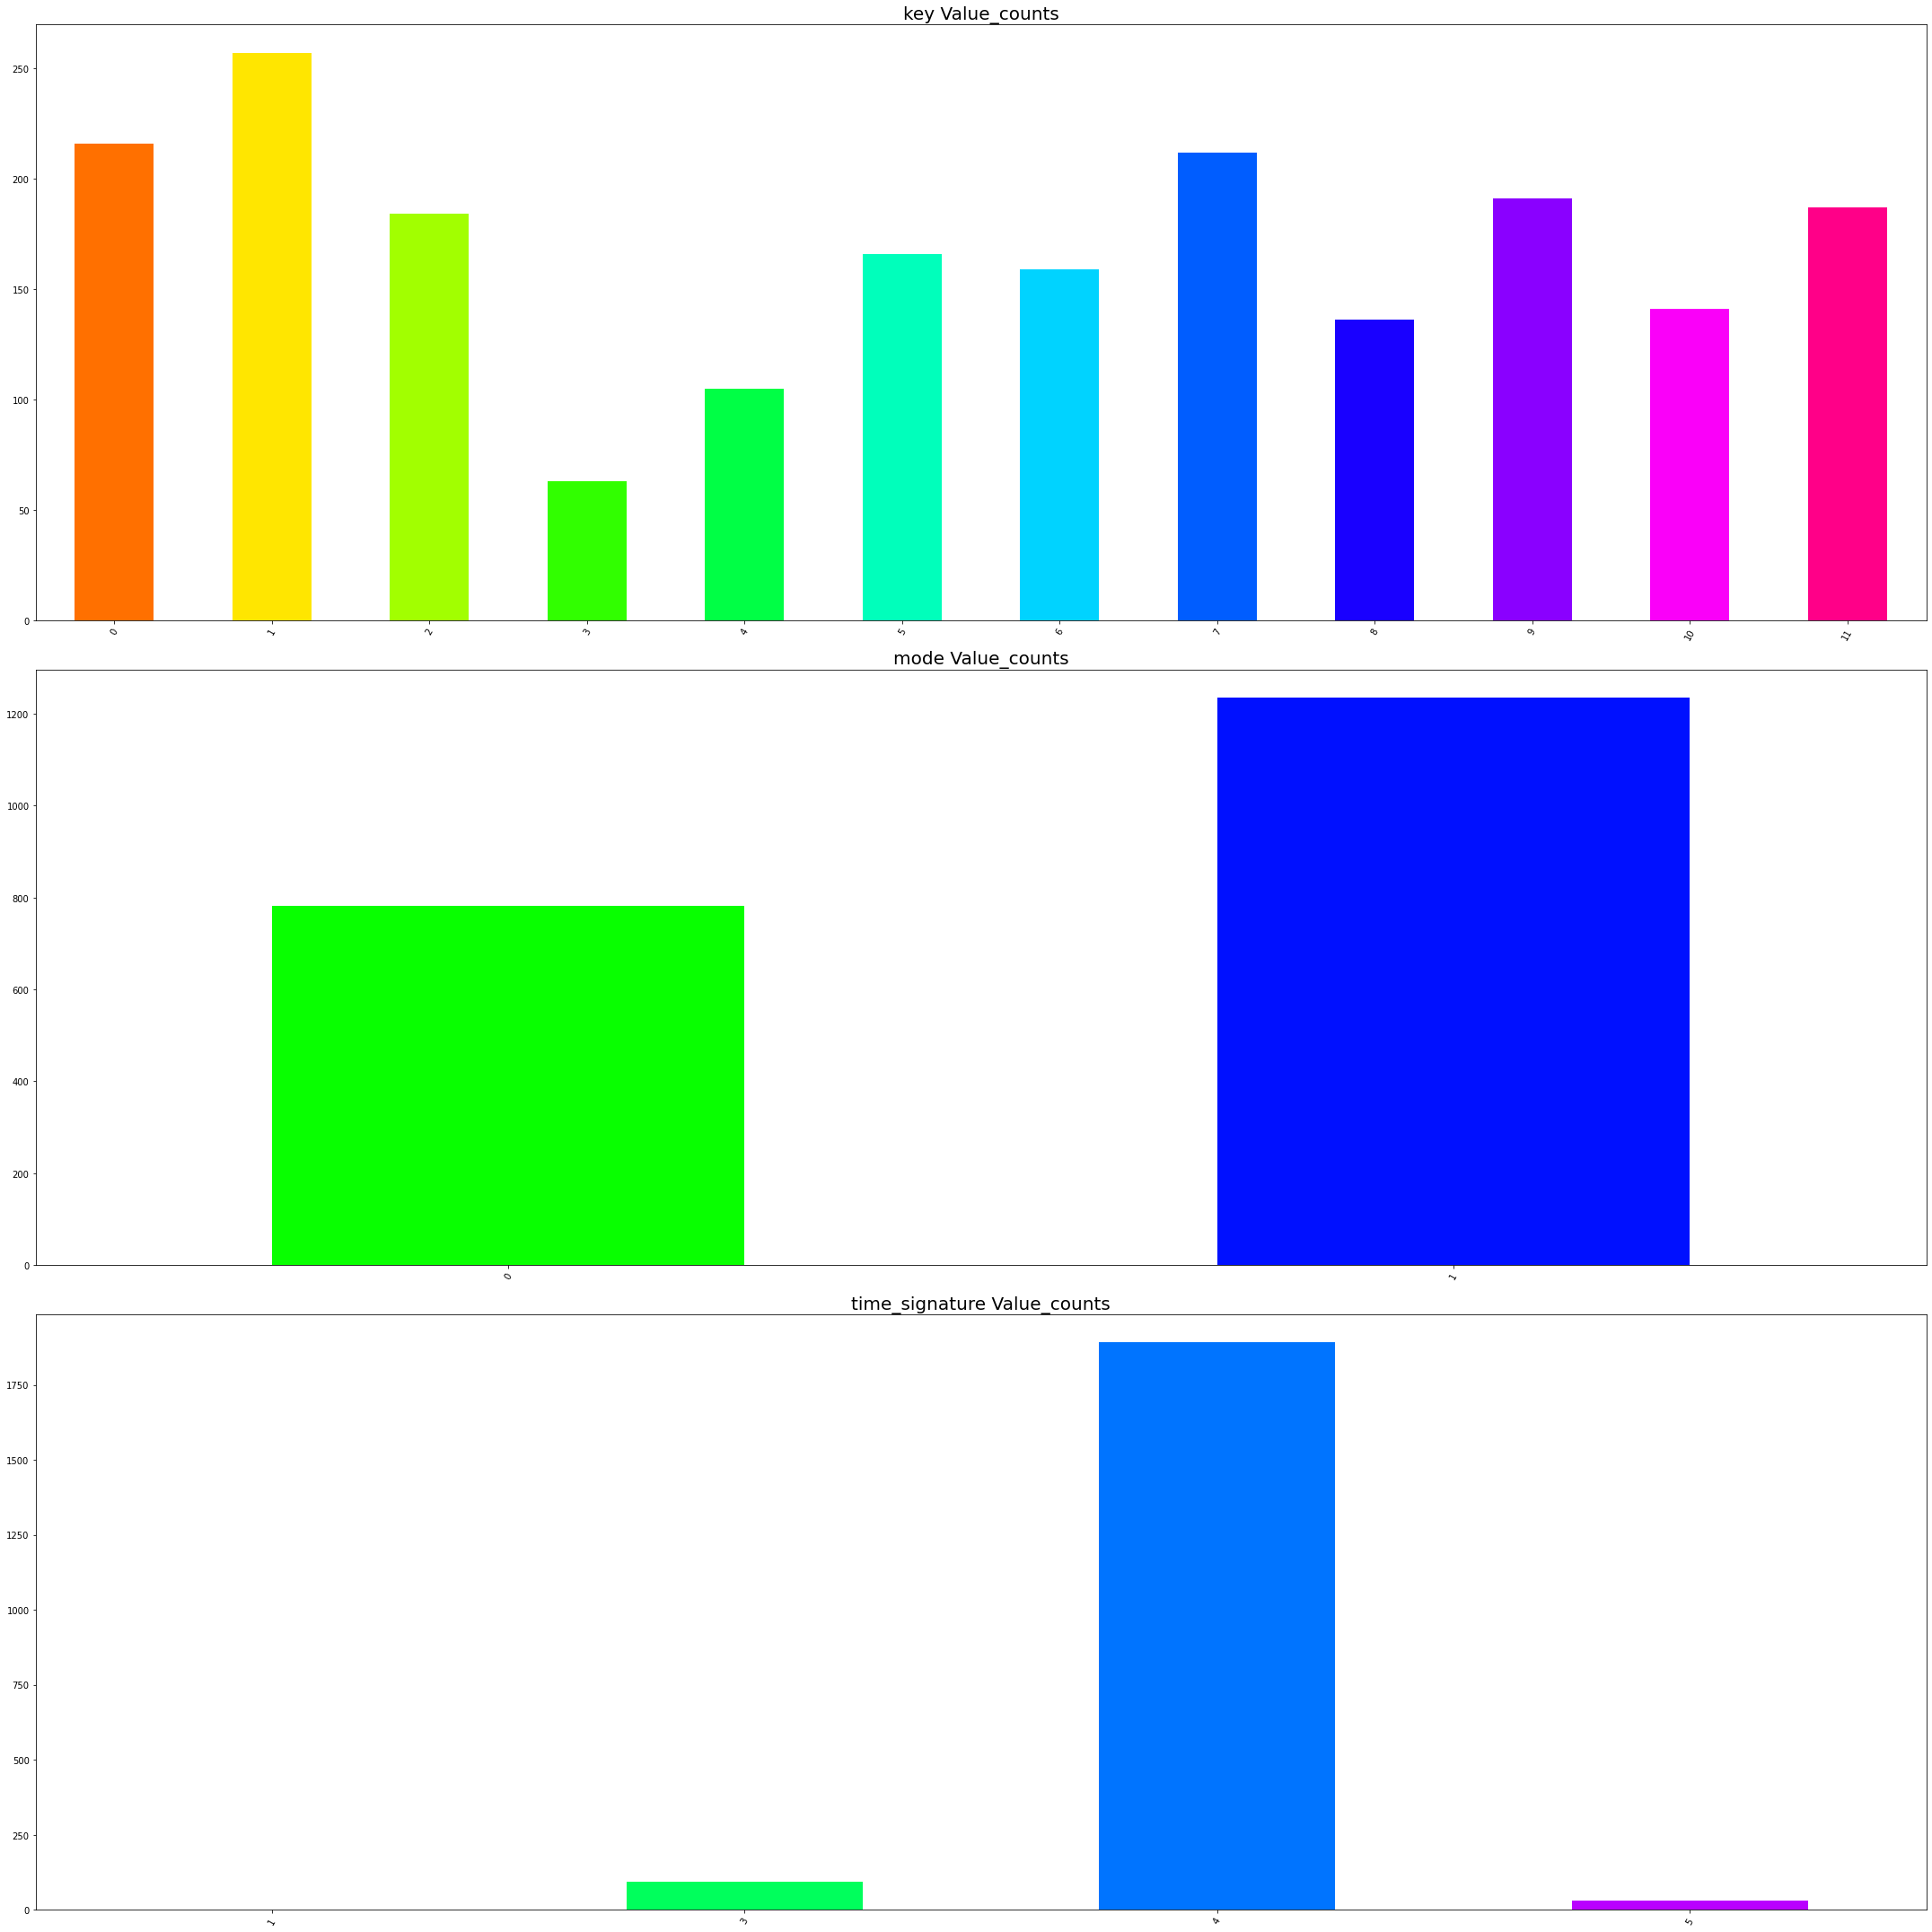

In [ ]:
plt.figure(figsize=(30,30))
for i,col in enumerate(int_col):
  import seaborn as sns
  colors = sns.color_palette('hsv',len(data[col].value_counts().sort_index()))
  ax=plt.subplot(3,1,i+1)
  plt.title(f'{col} Value_counts',fontsize=20)
  data[col].value_counts().sort_index().plot(kind='bar',color=colors)
  plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


## 상관관계 확인

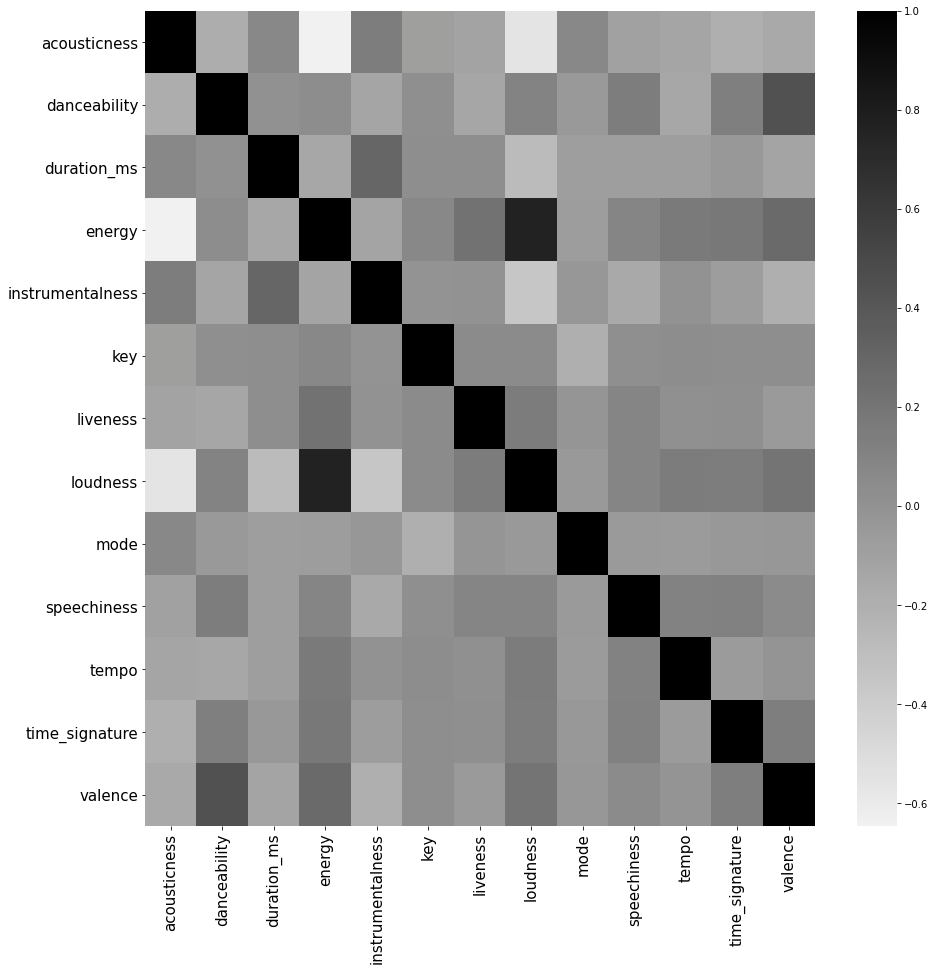

In [ ]:
import seaborn as sns                        #heatmap 만들기 위한 라이브러리
cmap = sns.light_palette("Black", as_cmap = True)  
plt.figure(figsize=(15,15))
plt.xticks(fontsize=15,rotation=60)
plt.yticks(fontsize=15)
sns.heatmap(data.corr(), annot = False, cmap = cmap)

plt.show()

<Figure size 1080x1080 with 0 Axes>

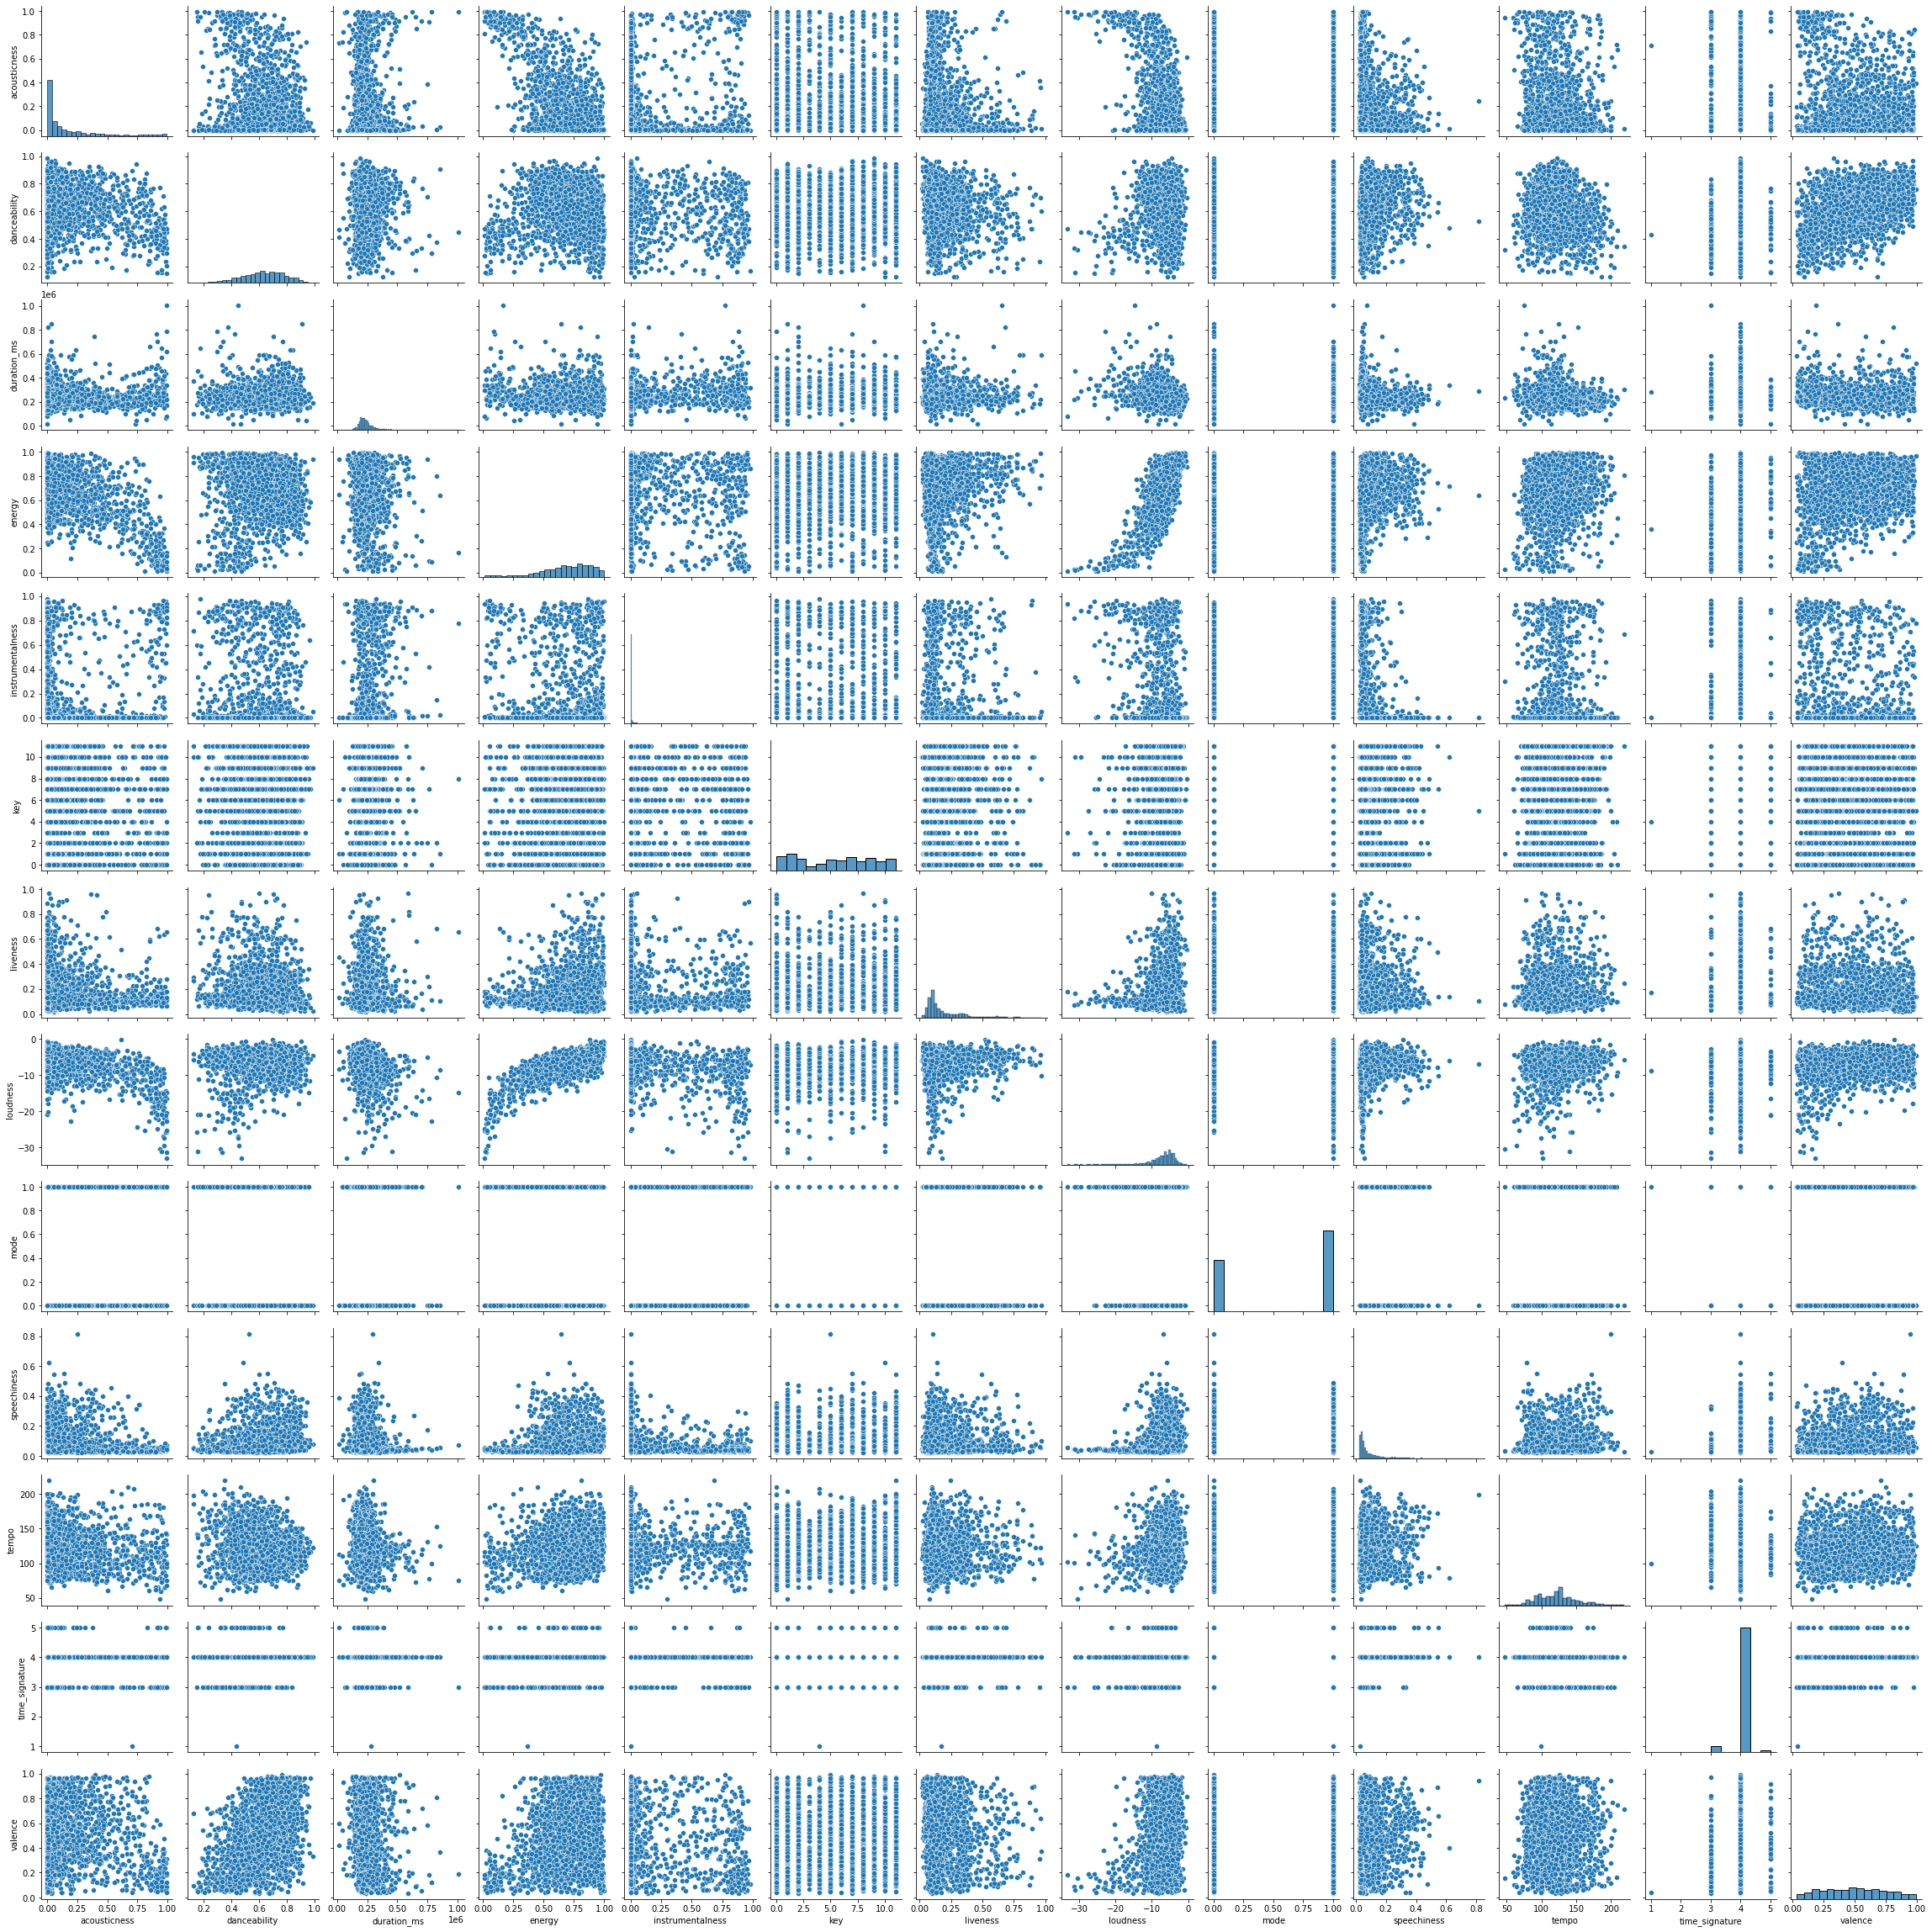

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(data)
plt.show()

## 다중공선성

초기 변수

In [ ]:
from statsmodels.stats import outliers_influence as outliers_influence
#from outliers_influence import variance_inflation_factor
#import statsmodels.stats.ouliers_influence.variance_inflation_factor as variance_inflation_factor 

vif = pd.DataFrame()
vif["VIF Factor"] = [outliers_influence.variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif["features"] = data.columns
vif = vif.sort_values('VIF Factor',axis=0)
vif;col1=vif['features'][:-1];vif#,col1

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,VIF Factor,features
4,1.645946,instrumentalness
9,2.237775,speechiness
0,2.625248,acousticness
8,2.677892,mode
6,2.736778,liveness
5,3.278670,key
12,7.226230,valence
10,8.770300,tempo
2,11.608211,duration_ms
7,12.375816,loudness


## 다중공선성 결과를 바탕으로 변수 제거 후 재 확인

In [ ]:
col = [data.columns]
df = data
while True:
  try:
    vif = pd.DataFrame()
    vif["VIF Factor"] = [outliers_influence.variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    vif = vif.sort_values('VIF Factor',axis=0)
    if max(vif['VIF Factor']) <=10:
      break
    else:
      col=vif['features'][:-1]
      df=df[col]
      continue
  except:
    continue
vif
# 총 9개 변수만 남음

,VIF Factor,features
0,1.547346,instrumentalness
1,2.140597,speechiness
2,2.282597,acousticness
4,2.446514,mode
3,2.472649,liveness
5,3.085018,key
6,4.314249,valence
7,6.435750,tempo
8,7.397919,loudness
9,8.971109,duration_ms


#Data Preparation

In [ ]:
train=pd.read_csv("/content/drive/Shareddrives/Spotify Recommendation/Train.csv")
test=pd.read_csv("/content/drive/Shareddrives/Spotify Recommendation/Test.csv")

In [ ]:
x_train=train.iloc[:, :-1]
y_train=train.iloc[:, -1:]
x_test=test.iloc[:, :-1]
y_test=test.iloc[:, -1:]

In [ ]:
x_train, x_val, y_train, y_val=train_test_split(x_train, y_train, test_size=0.2, 
                                                random_state=1, shuffle=True)

#1.  Boost 계열



## ADABoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier(random_state = 222)

In [ ]:
ada_param_grid = {
    'n_estimators': [10,20,30,40,50],
    'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

In [ ]:
ada_grid = GridSearchCV(ada, param_grid = ada_param_grid, scoring = "f1", n_jobs = -1, verbose = 1)
ada_gridsearch = ada_grid.fit(X_train, y_train)

In [ ]:
# 최적의 파라미터 찾기
print("최고 예측정확도 : {0: .4f}".format(ada_gridsearch.best_score_))
print("최적의 하이퍼 파라미터 : ", ada_gridsearch.best_params_)

In [ ]:
# 최적의 파라미터로 훈련
ada_best_para = ada_gridsearch.best_estimator_
ada_best_para.fit(X_train, y_train)

In [ ]:
#5fold Stratified 교차검증
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate

ada_clf = AdaBoostClassifier(learning_rate=0.5, n_estimators=40, random_state=222)

data = X_val
target = y_val

scores = cross_val_score(ada_clf, data, target, cv = 5 , scoring = 'f1')
print('교차 검증별 정확도: ', np.round(scores, 4))
print('평균 검증 정확도: ', np.round(np.mean(scores),4))

In [ ]:
#ADABoost test 데이터에 적용
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도(Accuracy): {:.4f}'.format(accuracy))
    print('정밀도(Precision): {:.4f}'.format(precision))
    print('재현율(Recall): {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [ ]:
#test 데이터 불러오기
test = pd.read_csv('test.csv',index_col=0)

y_test = test['target']
X_test = test.drop(['target'], axis=1)

In [ ]:
#test data에 적용
ada_test = ada_best_para.predict(X_test)
ada_accuracy = get_clf_eval(y_test, ada_test)
ada_accuracy

##GDBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import accuracy_score
import time

# GBM 수행시간 측정을 위함. 시작시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=222)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_val)
gb_accuracy = accuracy_score(y_val, gb_pred)

print('GBM 정확도: {:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {:.1f}초'.format(time.time() - start_time))

In [ ]:
gb_param_grid = {
    'n_estimators' : [100,300,500,700,900],
    'learning_rate' : [0.01,0.02,0.03,0.04,0.05,0.1,0.2]
}

In [ ]:
gb_grid = GridSearchCV(gb_clf, param_grid = gb_param_grid, cv=5, n_jobs = -1, verbose = 1)
gb_gridsearch = gb_grid.fit(X_train, y_train)

In [ ]:
# 최적의 파라미터 찾기
print("최고 예측정확도 : {0: .4f}".format(gb_gridsearch.best_score_))
print("최적의 하이퍼 파라미터 : ", gb_gridsearch.best_params_)

In [ ]:
# 최적의 파라미터로 훈련
gb_best_para = gb_gridsearch.best_estimator_
gb_best_para.fit(X_train, y_train)

In [ ]:
pred_gb = gb_best_para.predict(X_val)
print('GDBoost 정확도: {:.4f}'.format(accuracy_score(y_val, pred_gb)))

In [ ]:
#test data에 적용
gb_test = gb_best_para.predict(X_test)
gb_accuracy = get_clf_eval(y_test, gb_test)
gb_accuracy

## XGBoost
---------------------------------------------
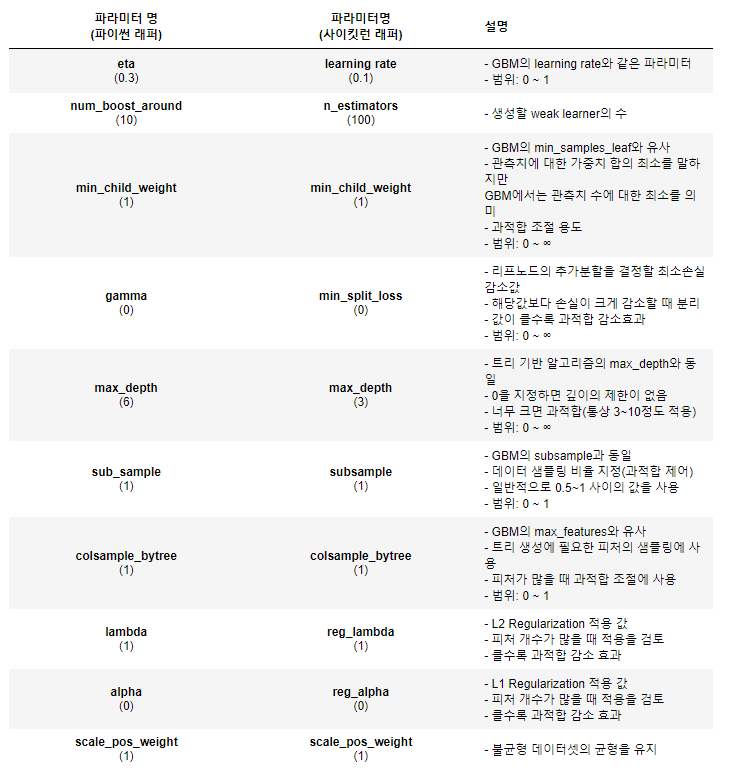

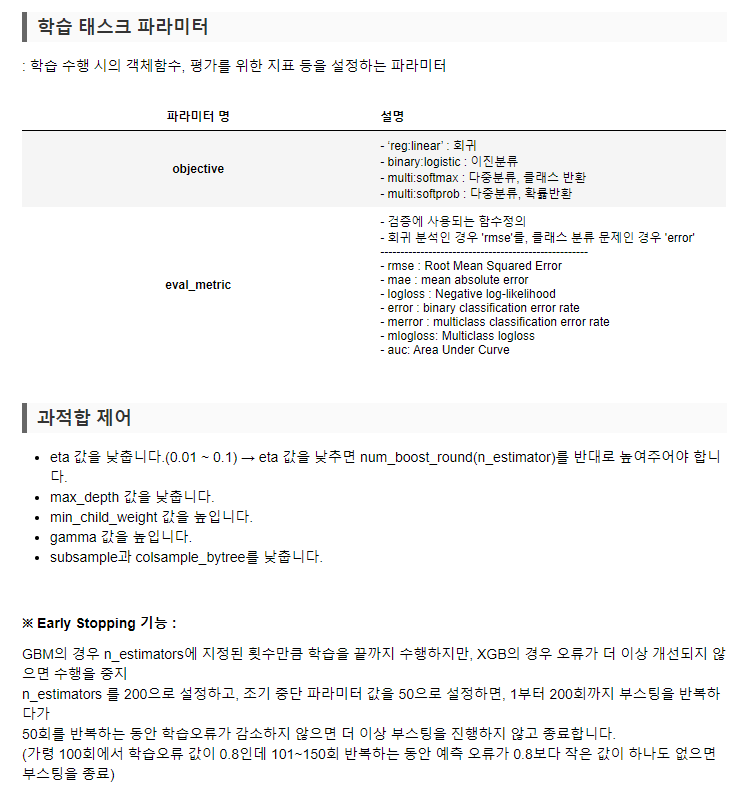

In [ ]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import XGBClassifier
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## normal

In [ ]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import XGBClassifier
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators = 1000, learning_rate = 0.02, max_depth = 4,objective='binary:logistic',booster='gbtree')#,feature_selector='greedy')
evals = [(x_valid, y_valid)]
xgb_wrapper.fit(x_train, y_train,eval_set=evals,eval_metric='logloss', early_stopping_rounds=1000)#,feature_selector='greedy')

[0]	validation_0-logloss:0.687994
Will train until validation_0-logloss hasn't improved in 1000 rounds.
[1]	validation_0-logloss:0.68306
[2]	validation_0-logloss:0.677608
[3]	validation_0-logloss:0.673053
[4]	validation_0-logloss:0.668642
[5]	validation_0-logloss:0.66379
[6]	validation_0-logloss:0.659696
[7]	validation_0-logloss:0.655203
[8]	validation_0-logloss:0.651299
[9]	validation_0-logloss:0.646974
[10]	validation_0-logloss:0.64308
[11]	validation_0-logloss:0.639289
[12]	validation_0-logloss:0.635429
[13]	validation_0-logloss:0.631796
[14]	validation_0-logloss:0.62843
[15]	validation_0-logloss:0.624907
[16]	validation_0-logloss:0.621675
[17]	validation_0-logloss:0.618367
[18]	validation_0-logloss:0.615562
[19]	validation_0-logloss:0.612476
[20]	validation_0-logloss:0.609415
[21]	validation_0-logloss:0.606566
[22]	validation_0-logloss:0.604015
[23]	validation_0-logloss:0.601355
[24]	validation_0-logloss:0.59891
[25]	validation_0-logloss:0.596613
[26]	validation_0-logloss:0.594275


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pred_probs = xgb_wrapper.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[72 28]
 [24 78]]

정확도: 0.7426
정밀도: 0.7358
재현율: 0.7647
F1: 0.7500
AUC: 0.7424


### 모델 저장, 불러오기

In [ ]:
import pickle
from sklearn.externals import joblib
saved_model = pickle.dumps(xgb_wrapper)
directory = Directory('XGBoost')
fname=f'{directory}Normal_XGBoost.pkl'
joblib.dump(xgb_wrapper, fname) 

clf_from_joblib = joblib.load(fname) 
clf_from_joblib.predict(x_test)

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0])

### pca

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators = 1000, learning_rate = 0.02, max_depth = 4,objective='binary:logistic',booster='gbtree')#,feature_selector='greedy')
evals = [(pca_valid, y_valid)]
xgb_wrapper.fit(pca_train, y_train,eval_set=evals,eval_metric='logloss')#,feature_selector='greedy')
pred_probs = xgb_wrapper.predict(pca_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

[0]	validation_0-logloss:0.690104
[1]	validation_0-logloss:0.687185
[2]	validation_0-logloss:0.685375
[3]	validation_0-logloss:0.682653
[4]	validation_0-logloss:0.681215
[5]	validation_0-logloss:0.67986
[6]	validation_0-logloss:0.677387
[7]	validation_0-logloss:0.675813
[8]	validation_0-logloss:0.673986
[9]	validation_0-logloss:0.671736
[10]	validation_0-logloss:0.670241
[11]	validation_0-logloss:0.66927
[12]	validation_0-logloss:0.6679
[13]	validation_0-logloss:0.665997
[14]	validation_0-logloss:0.664616
[15]	validation_0-logloss:0.662836
[16]	validation_0-logloss:0.661739
[17]	validation_0-logloss:0.660651
[18]	validation_0-logloss:0.658984
[19]	validation_0-logloss:0.658037
[20]	validation_0-logloss:0.656486
[21]	validation_0-logloss:0.655635
[22]	validation_0-logloss:0.654795
[23]	validation_0-logloss:0.65348
[24]	validation_0-logloss:0.652451
[25]	validation_0-logloss:0.651492
[26]	validation_0-logloss:0.65032
[27]	validation_0-logloss:0.649416
[28]	validation_0-logloss:0.648753
[

### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid=[
            {'booster':['gbtree'],'learning_rate':[0.01,0.001,0.005,0.05,0.1],
             'max_depth':[4,5,6,7],'min_split_loss':[0.001,0.01,0.1],'n_estimators':[1000]},
            ]
#skl.metrics.SCORERS.keys() : scoring 종류 확인
xgb_wrapper = XGBClassifier()
grid_search=GridSearchCV(xgb_wrapper,param_grid,scoring='f1',cv=5,verbose=2,n_jobs=-1)
grid_search.fit(x_train,y_train)
best_params = grid_search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


In [ ]:
evals = [(x_valid, y_valid)]
grid_search.best_estimator_.fit(x_train,y_train,eval_metric='error',eval_set=evals,early_stopping_rounds=70)
best_clf=grid_search.best_estimator_
pred_probs = grid_search.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

[0]	validation_0-error:0.263736
Will train until validation_0-error hasn't improved in 70 rounds.
[1]	validation_0-error:0.28022
[2]	validation_0-error:0.285714
[3]	validation_0-error:0.291209
[4]	validation_0-error:0.274725
[5]	validation_0-error:0.269231
[6]	validation_0-error:0.285714
[7]	validation_0-error:0.291209
[8]	validation_0-error:0.28022
[9]	validation_0-error:0.285714
[10]	validation_0-error:0.285714
[11]	validation_0-error:0.291209
[12]	validation_0-error:0.285714
[13]	validation_0-error:0.28022
[14]	validation_0-error:0.274725
[15]	validation_0-error:0.269231
[16]	validation_0-error:0.263736
[17]	validation_0-error:0.263736
[18]	validation_0-error:0.258242
[19]	validation_0-error:0.258242
[20]	validation_0-error:0.258242
[21]	validation_0-error:0.252747
[22]	validation_0-error:0.252747
[23]	validation_0-error:0.252747
[24]	validation_0-error:0.258242
[25]	validation_0-error:0.252747
[26]	validation_0-error:0.263736
[27]	validation_0-error:0.263736
[28]	validation_0-error

In [ ]:
best_params=grid_search.best_params_
best_params

{'booster': 'gbtree',
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_split_loss': 0.001,
 'n_estimators': 700}

### 모델 저장, 불러오기

In [ ]:
import pickle
from sklearn.externals import joblib
saved_model = pickle.dumps(grid_search.best_estimator_)
directory = Directory('XGBoost')
fname=f'{directory}GridSearch_XGBoost.pkl'
joblib.dump(best_clf, fname) 

clf_from_joblib = joblib.load(fname)
clf_from_joblib.get_params 
#clf_from_joblib.predict(x_test)

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, min_split_loss=0.1, missing=nan,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)>

### RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform


In [ ]:
#param_grid=[
#            {'booster':['gbtree'],'learning_rate':np.linspace(0.005,0.015,11).tolist(),
#             'max_depth':[5,6,7],'min_split_loss':np.linspace(0.05,0.15,11).tolist(),'n_estimators':np.linspace(650,750,3,dtype=int).tolist()},
#            ]
param_grid=[
            {'booster':['gbtree'],'learning_rate':[0.01,0.001,0.005,0.05,0.1],
             'max_depth':[4,5,6,7],'min_split_loss':[0.001,0.01,0.1],'n_estimators':[500,600,700,800,900,1000,1100,1200]},
            {'booster':['gblinear'],'learning_rate':[0.01,0.001,0.005],
             'reg_lambda':[0.001,0.0001,0],'reg_alpha':[0.001,0.0001,0]}
            ]
#skl.metrics.SCORERS.keys() : scoring 종류 확인
xgb_wrapper = XGBClassifier(objective='binary:logistic')
rand_search=RandomizedSearchCV(xgb_wrapper,param_grid,n_iter=100,scoring='f1',cv=5,verbose=2,n_jobs=-1)
rand_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                         'learning_rate': [0.01, 0.001, 0.005,
                                                           0.05, 0.1],
                           

In [ ]:
evals = [(x_valid, y_valid)]
rand_params = rand_search.best_params_
print(rand_params)
rand_search.best_estimator_.fit(x_train,y_train,eval_metric='error',eval_set=evals,early_stopping_rounds=70)
pred_probs = rand_search.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

{'n_estimators': 800, 'min_split_loss': 0.001, 'max_depth': 4, 'learning_rate': 0.05, 'booster': 'gbtree'}
[0]	validation_0-error:0.269231
Will train until validation_0-error hasn't improved in 70 rounds.
[1]	validation_0-error:0.263736
[2]	validation_0-error:0.269231
[3]	validation_0-error:0.269231
[4]	validation_0-error:0.252747
[5]	validation_0-error:0.252747
[6]	validation_0-error:0.258242
[7]	validation_0-error:0.252747
[8]	validation_0-error:0.247253
[9]	validation_0-error:0.258242
[10]	validation_0-error:0.252747
[11]	validation_0-error:0.247253
[12]	validation_0-error:0.258242
[13]	validation_0-error:0.247253
[14]	validation_0-error:0.252747
[15]	validation_0-error:0.258242
[16]	validation_0-error:0.252747
[17]	validation_0-error:0.258242
[18]	validation_0-error:0.263736
[19]	validation_0-error:0.263736
[20]	validation_0-error:0.258242
[21]	validation_0-error:0.258242
[22]	validation_0-error:0.258242
[23]	validation_0-error:0.252747
[24]	validation_0-error:0.252747
[25]	validat

## CatBoost Classifier

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
#categorical_features_indices = [4, 6]
model=CatBoostClassifier(custom_loss=["Accuracy"], logging_level='Silent')

In [ ]:
# fit on train set
model.fit(x_train, y_train,  eval_set=(x_val, y_val), logging_level="Verbose")

In [ ]:
# evaulate on test set
y_pred=model.predict(x_test)
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred))

In [ ]:
# calculate importance(weights) of each feature
model.feature_importances_

In [ ]:
# show tree plot
model.plot_tree(tree_idx=0)

# 3. Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(train_data, train_target)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [8,10,12],
    'n_estimators': [500,600,700]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(train_data, train_target)
grid_search.best_params_

In [ ]:
grid_search.best_params_
grid_search.best_estimator_
best_grid = grid_search.best_estimator_

In [ ]:
## 테스트셋 적용 ##
## 테스트셋 적용 ##
## Accuracy = 69.80
## F1 = 71.09
grid_accuracy = evaluate(best_grid, test_data, test_target)

In [ ]:
## 모델 만들기 ## 
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1,random_state=42)
rnd_clf.fit(train_data, train_target)

In [ ]:
## 테스트셋 적용 ## 
## acc: 70.79 ##
## F1 : 72.03 ##

model_rf_test = rnd_clf.predict(test_data) #test 데이터로 예측
print('Accuracy =', accuracy_score(model_rf_test, test_target)) # test target값 예측 
print('F1 =', f1_score(model_rf_test, test_target))

In [ ]:
confusion = confusion_matrix(model_rf_test, test_target)
accuracy = accuracy_score(model_rf_test, test_target)
F1 = f1_score(model_rf_test, test_target)

# 3. Regulariztion

## LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
lasso=Lasso()
print(lasso.get_params().keys())

In [ ]:
lasso = Lasso(random_state=1, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds)
clf.fit(x_train, y_train)

In [ ]:
Lasso_best = clf.best_estimator_

In [ ]:
y_pred = Lasso_best.predict(x_valid)
y_pred1=pd.Series(y_pred)
print(accuracy_score(y_valid, y_pred1.round()))

In [ ]:
y_pred = Lasso_best.predict(x_test)
y_pred1=pd.Series(y_pred)

In [ ]:
get_clf_eval(y_test,y_pred1.round())

## RIDGE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [ ]:
LR=LogisticRegression()

In [ ]:
from sklearn.model_selection import GridSearchCV

# 파라메터 후보
param_grid = {'C': [9.5,9.6,9.7,9.8,9.9,10,10.1,10.2,10.3,10.4,10.5],
              'penalty': ['l2']}

# 그리드 서치 진행

grid_search = GridSearchCV(LR, param_grid, cv=KFold(n_splits=10))

# 최종 모델 성능 점검

grid_search.fit(x_train,y_train)

In [ ]:
Ridge_best = grid_search.best_estimator_

In [ ]:
y_pred = Ridge_best.predict(x_valid)
y_pred1=pd.Series(y_pred)
print(accuracy_score(y_valid, y_pred1.round()))

In [ ]:
y_pred = Ridge_best.predict(x_test)
y_pred1=pd.Series(y_pred)

In [ ]:
get_clf_eval(y_test,y_pred1.round())

## Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
model=ElasticNet()

In [ ]:
# 파라메터 후보
param_grid = {'alpha': [0.0098,0.0099,0.001,0.002,0.003,0.004,0.005],'l1_ratio':[0.001,0.01,0.1,1]}

# 그리드 서치 진행

grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=10))

In [ ]:
grid_search.fit(x_train,y_train)

In [ ]:
ElasticNet_best = grid_search.best_estimator_

In [ ]:
y_pred = ElasticNet_best.predict(x_valid)
y_pred1=pd.Series(y_pred)
print(accuracy_score(y_valid, y_pred1.round()))

In [ ]:
y_pred = ElasticNet_best.predict(x_test)
y_pred1=pd.Series(y_pred)

In [ ]:
get_clf_eval(y_test,y_pred1.round())

## Logistic Regression + Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selectK = SelectKBest(score_func=f_classif, k=5)
train_xK = selectK.fit_transform(train_x, train_y)
test_xK = selectK.fit_transform(x_test, y_test)

In [ ]:
grid_search.fit(train_xK,train_y)

In [ ]:
Featureselection_best = grid_search.best_estimator_

In [ ]:
y_pred = Featureselection_best.predict(test_xK)
print(accuracy_score(y_test, y_pred.round()))
pd.crosstab(y_test, y_pred, rownames = ["True"], colnames = ["Predicted"], margins = True)

# 4. Voting

In [ ]:
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.linear_model import ElasticNet,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

###(1) logistic regression

In [ ]:
# 보팅 적용을 위한 개별 모델은 로지스틱 회귀와 KNN입니다.

logistic_param = [
            {'penalty':['l1'],
             'C':np.logspace(-4,0,5),
             'class_weight':['balanced',None],
             'solver':['liblinear','saga']},
             {'penalty':['l2'],
             'C':np.logspace(-4,0,5),
             'class_weight':['balanced',None],
             'solver':['newton-cg','lbfgs','sag','saga'],
              'n_jobs':[-1]},
             {'penalty':['elasticnet'],
             'C':np.logspace(-4,0,5),
             'class_weight':['balanced',None],
             'solver':['liblinear'],
              'n_jobs':[-1],
              'l1_ratio':np.logspace(-1,0,10)} 
            ]
logistic_reg = LogisticRegression()
logistic_grid = GridSearchCV(logistic_reg,logistic_param,scoring='f1',
                                    cv=5,n_jobs=-1,verbose=2,return_train_score=True)
logistic_grid.fit(x_train,y_train)
evals = [(x_valid, y_valid)]
logistic_params = logistic_grid.best_params_
print(logistic_params)
logistic_grid.best_estimator_.fit(x_train,y_train)
pred_probs = logistic_grid.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 zZ결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    4.7s


{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
오차행렬:
 [[  0 100]
 [  0 102]]

정확도: 0.5050
정밀도: 0.5050
재현율: 1.0000
F1: 0.6711
AUC: 0.5000


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   14.9s finished


### (2) knn

In [ ]:
knn_params =[{'n_neighbors':[3,4,5,6,7],'weights':['uniform','distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan']}]
knn = KNeighborsClassifier(n_jobs=-1)
grid_search=GridSearchCV(knn,knn_params,scoring='f1',cv=5,verbose=2,n_jobs=-1)
grid_search.fit(x_train,y_train)
best_params = grid_search.best_params_
grid_search.best_estimator_.fit(x_train,y_train)
best_clf = grid_search.best_estimator_
pred_probs = grid_search.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   18.2s


오차행렬:
 [[70 30]
 [45 57]]

정확도: 0.6287
정밀도: 0.6552
재현율: 0.5588
F1: 0.6032
AUC: 0.6294


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   23.5s finished


##### 모델 저장, 불러오기

In [ ]:
import pickle
from sklearn.externals import joblib
saved_model = pickle.dumps(best_clf)
directory = Directory('KNN')
fname=f'{directory}Grid_knn.pkl'
joblib.dump(best_clf, fname) 

clf_from_joblib = joblib.load(fname) 

pred_probs = clf_from_joblib.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 zZ결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[70 30]
 [45 57]]

정확도: 0.6287
정밀도: 0.6552
재현율: 0.5588
F1: 0.6032
AUC: 0.6294


### (3) SVM

#### normal

In [ ]:
from sklearn.svm import LinearSVC,NuSVC
svc_params=[{'nu':np.linspace(0,1,100),
             'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma':['scale','auto']}
             ]
svc=NuSVC()
grid_search=RandomizedSearchCV(svc,svc_params,scoring='f1',n_iter=100,cv=5,verbose=2,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed: 111.7min
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed: 171.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 215.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=NuSVC(break_ties=False, cache_size=200,
                                   class_weight=None, coef0=0.0,
                                   decision_function_shape='ovr', degree=3,
                                   gamma='scale', kernel='rbf', max_iter=-1,
                                   nu=0.5, probability=False, random_state=None,
                                   shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions=[{'gamma': ['sca...
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ])}],
                   pre_dispatch='2*n_jobs', random_sta

In [ ]:
best_params = grid_search.best_params_
grid_search.best_estimator_.fit(x_train,y_train)
best_clf = grid_search.best_estimator_

In [ ]:
pred_probs = grid_search.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[70 30]
 [45 57]]

정확도: 0.6287
정밀도: 0.6552
재현율: 0.5588
F1: 0.6032
AUC: 0.6294


##### 모델 저장, 불러오기

In [ ]:
import pickle
from sklearn.externals import joblib
#saved_model = pickle.dumps(best_clf)
directory = Directory('SVM')
fname=f'{directory}Grid_x_train_SVM.pkl'
joblib.dump(best_clf, fname) 

clf_from_joblib = joblib.load(fname) 

pred_probs = clf_from_joblib.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 zZ결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[70 30]
 [35 67]]

정확도: 0.6782
정밀도: 0.6907
재현율: 0.6569
F1: 0.6734
AUC: 0.6784


In [ ]:
from sklearn.svm import LinearSVC,NuSVC
svc_params=[{'penalty':['l1'],'loss':['squared_hinge'],
             'C':np.linspace(0,1,10)},
            {'penalty':['lw'],'loss':['hinge','squared_hinge'],
             'C':np.linspace(0,1,10)}
             ]
svc=LinearSVC(class_weight='balanced',random_state=3,verbose=3,dual=False)
grid_search=GridSearchCV(svc,svc_params,scoring='f1',cv=5,verbose=2,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[LibLinear]

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=3, tol=0.0001, verbose=3),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'loss': ['squared_hinge'], 'penalty': ['l1']},
                         {'C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'loss': ['hinge', 'squared_hinge'],
                          'penalty': ['lw']}],
             pre_dispatch='2*n_jobs', refit=Tr

In [ ]:
best_params = grid_search.best_params_
grid_search.best_estimator_.fit(x_train,y_train)
best_clf = grid_search.best_estimator_
pred_probs = grid_search.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

[LibLinear]오차행렬:
 [[60 40]
 [33 69]]

정확도: 0.6386
정밀도: 0.6330
재현율: 0.6765
F1: 0.6540
AUC: 0.6382


##### 모델 저장, 불러오기

In [ ]:
import pickle
from sklearn.externals import joblib
#saved_model = pickle.dumps(grid_search.best_estimator_)
directory = Directory('XGBoost')
fname=f'{directory}GridSearch_XGBoost.pkl'
joblib.dump(grid_search.best_estimator_, fname) 

clf_from_joblib = joblib.load(fname) 
clf_from_joblib.predict(x_test)
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[70 30]
 [35 67]]

정확도: 0.6782
정밀도: 0.6907
재현율: 0.6569
F1: 0.6734
AUC: 0.6784


### (4) Neural Network

#### Grid Search

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_params=[{'solver':['adam'], 
              'hidden_layer_sizes':[(16,),(32,16),(64,32,16)],
             'alpha':[0,0.0001],
             'early_stopping':[True,False],
             'learning_rate':['constant','invscaling','adaptive'],
             'max_iter':[200,250,300]},
            {'solver':['sgd'],
             'momentum':[0.9,0.99],
             'hidden_layer_sizes':[(16,),(32,16),(64,32,16)],
             'alpha':[0,0.0001],
             'early_stopping':[True,False],
             'learning_rate':['constant','invscaling','adaptive'],
             'max_iter':[200,250,300]
             }
            ]
mlp = MLPClassifier(random_state=3,learning_rate_init=0.1,power_t=0.1,verbose=2)
grid_search=GridSearchCV(mlp,mlp_params,scoring='f1',cv=5,verbose=2,n_jobs=-1)
grid_search.fit(x_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  6.9min finished


Iteration 1, loss = 1.45580133
Validation score: 0.506098
Iteration 2, loss = 0.82745364
Validation score: 0.463415
Iteration 3, loss = 0.70451896
Validation score: 0.512195
Iteration 4, loss = 0.68954666
Validation score: 0.530488
Iteration 5, loss = 0.69088378
Validation score: 0.524390
Iteration 6, loss = 0.68807330
Validation score: 0.542683
Iteration 7, loss = 0.68506195
Validation score: 0.560976
Iteration 8, loss = 0.68236274
Validation score: 0.597561
Iteration 9, loss = 0.67867261
Validation score: 0.567073
Iteration 10, loss = 0.67502435
Validation score: 0.585366
Iteration 11, loss = 0.66817048
Validation score: 0.628049
Iteration 12, loss = 0.66349021
Validation score: 0.640244
Iteration 13, loss = 0.65380651
Validation score: 0.652439
Iteration 14, loss = 0.65179692
Validation score: 0.646341
Iteration 15, loss = 0.64872423
Validation score: 0.664634
Iteration 16, loss = 0.64782128
Validation score: 0.652439
Iteration 17, loss = 0.64349305
Validation score: 0.682927
Iterat

{'alpha': 0,
 'early_stopping': True,
 'hidden_layer_sizes': (16,),
 'learning_rate': 'constant',
 'max_iter': 200,
 'solver': 'adam'}

In [ ]:
evals = [(x_valid, y_valid)]
best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_clf.fit(x_train,y_train)

Iteration 1, loss = 1.45580133
Validation score: 0.506098
Iteration 2, loss = 0.82745364
Validation score: 0.463415
Iteration 3, loss = 0.70451896
Validation score: 0.512195
Iteration 4, loss = 0.68954666
Validation score: 0.530488
Iteration 5, loss = 0.69088378
Validation score: 0.524390
Iteration 6, loss = 0.68807330
Validation score: 0.542683
Iteration 7, loss = 0.68506195
Validation score: 0.560976
Iteration 8, loss = 0.68236274
Validation score: 0.597561
Iteration 9, loss = 0.67867261
Validation score: 0.567073
Iteration 10, loss = 0.67502435
Validation score: 0.585366
Iteration 11, loss = 0.66817048
Validation score: 0.628049
Iteration 12, loss = 0.66349021
Validation score: 0.640244
Iteration 13, loss = 0.65380651
Validation score: 0.652439
Iteration 14, loss = 0.65179692
Validation score: 0.646341
Iteration 15, loss = 0.64872423
Validation score: 0.664634
Iteration 16, loss = 0.64782128
Validation score: 0.652439
Iteration 17, loss = 0.64349305
Validation score: 0.682927
Iterat

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(16,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.1,
              random_state=3, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=2, warm_start=False)

In [ ]:
pred_probs = grid_search.best_estimator_.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[70 30]
 [35 67]]

정확도: 0.6782
정밀도: 0.6907
재현율: 0.6569
F1: 0.6734
AUC: 0.6784


#### 모델 저장, 불러오기

In [ ]:
import pickle
from sklearn.externals import joblib
saved_model = pickle.dumps(grid_search.best_estimator_)
directory = Directory('NueralNetwork')
fname=f'{directory}GridSearch_NN.pkl'
joblib.dump(grid_search.best_estimator_, fname) 

clf_from_joblib = joblib.load(fname) 
clf_from_joblib.predict(x_test)

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0])

### Final :Voting

#####(1) XGB + KNN + SVM + MLP

In [ ]:
# 개별모델을 소프트보팅 기반의 앙상블 모델로 구현한 분류기
xgb = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/XGBoost/Normal_XGBoost.pkl') 
knn =joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/KNN/Grid_knn.pkl')
svm = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/SVM/Grid_x_train_SVM.pkl')
mlp = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/NueralNetwork/GridSearch_NN.pkl')


voting_model = VotingClassifier(estimators=[ ('XGBoost', xgb), ('KNN', knn),('SVM',svm),('MLP',mlp)], voting='soft',n_jobs=-1)
voting_model.fit(x_train,y_train)

VotingClassifier(estimators=[('XGBoost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.02,
                                            max_delta_step=0, max_depth=4,
                                            min_child_weight=1, missing=nan,
                                            n_estimators=1000, n_jobs=1,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_w...
                                            epsilon=1e-08,
                                            hidden_lay

In [ ]:
pred_probs = voting_model.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 zZ결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[73 27]
 [33 69]]

정확도: 0.7030
정밀도: 0.7188
재현율: 0.6765
F1: 0.6970
AUC: 0.7032


#####(2) XGB + MLP

In [ ]:
# 개별모델을 소프트보팅 기반의 앙상블 모델로 구현한 분류기
xgb = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/XGBoost/Normal_XGBoost.pkl') 
knn =joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/KNN/Grid_knn.pkl')
svm = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/SVM/Grid_x_train_SVM.pkl')
mlp = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/NueralNetwork/GridSearch_NN.pkl')


voting_model = VotingClassifier(estimators=[ ('XGBoost', xgb), ('MLP',mlp)], voting='soft',n_jobs=-1)
voting_model.fit(x_train,y_train)
pred_probs = voting_model.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 zZ결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[69 31]
 [27 75]]

정확도: 0.7129
정밀도: 0.7075
재현율: 0.7353
F1: 0.7212
AUC: 0.7126


#####(3) XGB_w.o_Grid + XGB_w_Grid

In [ ]:
xgb_normal = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/XGBoost/Normal_XGBoost.pkl') 
xgb_grid = joblib.load('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Models/XGBoost/GridSearch_XGBoost.pkl') 
#voting_model = VotingClassifier(estimators=[ ('XGBoost_Normal', xgb_normal), ('XGBoost_Grid', xgb_grid)], voting='soft',n_jobs=-1)
voting_model = VotingClassifier(estimators=[ ('XGBoost_Normal', xgb_normal), ('XGBoost_Grid', xgb_grid)], voting='hard',n_jobs=-1)
voting_model.fit(x_train,y_train)
pred_probs = voting_model.predict(x_test)
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 zZ결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds)

오차행렬:
 [[70 30]
 [28 74]]

정확도: 0.7129
정밀도: 0.7115
재현율: 0.7255
F1: 0.7184
AUC: 0.7127


##### (4) ADAB + GDB

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators = [('ada', ada), ('gb', gb)], voting="hard")
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('ada', AdaBoostClassifier(random_state=222)),
                             ('gb',
                              GradientBoostingClassifier(random_state=222))])

In [ ]:
for clf in (ada, gb):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    get_clf_eval(y_test, y_pred)

오차행렬:
 [[66 34]
 [25 77]]

정확도(Accuracy): 0.7079
정밀도(Precision): 0.6937
재현율(Recall): 0.7549
F1: 0.7230
AUC: 0.7075
오차행렬:
 [[68 32]
 [28 74]]

정확도(Accuracy): 0.7030
정밀도(Precision): 0.6981
재현율(Recall): 0.7255
F1: 0.7115
AUC: 0.7027
